In [9]:
#processing
import pandas as pd
import numpy as np
import IDF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import scipy
scaler = StandardScaler()
label = LabelEncoder()
import scikitplot as skplt
#sql
import pymysql.cursors 
#NLP
import nltk
import re
import pymorphy2
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#warnings
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline
#vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#model 
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
#classificators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.externals import joblib
from datetime import datetime

In [22]:
from time import strptime

datetime.strptime('21feb17:13:08:28', '%d%b%y:%H:%M:%S')

datetime.datetime(2017, 2, 21, 13, 8, 28)

In [17]:
strptime('FEB','%b')

time.struct_time(tm_year=1900, tm_mon=2, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=32, tm_isdst=-1)

## Loading and 1st processing

In [2]:
#Подключиться к базе данных
def con():
    conn = pymysql.connect(host='192.168.64.1', port=3306, user='i.serov', password='X3*1Uy(F', db='mysql')
    return conn

In [3]:
%%time
df = pd.read_sql('''
SELECT
    p.credit_id as crd_id,
    date_attempt,
    amount,
    success,
    iba.*,
    cc1.*,
    w.education,w.attested_income,w.employment, w.monthly_expenses,w.loan_reason,
    pd.marital_status,pd.sex,pd.place_of_birth,pd.net_worth,
    i.device_new,i.device_type, i.realipaddress_loc_city, 
    i.ruleset_score,
    day(p.date_attempt)                            AS day_of_month_of_spisanie,
    28 - day(p.date_attempt) as diff_good_day_attempt_day,
    dayofweek(p.date_attempt)                      AS day_of_week_of_spisanie,
    month(p.date_attempt)                      AS month_of_spisanie,
    datediff(day(w.next_salary_date), day(c.date_requested)) AS days_bef_sal,
    datediff(day(w.next_salary_date), day(p.date_attempt))   AS days_bef_income,
    datediff(pd.birthday, c.date_requested) AS age,
    p.amount / cc1.expired_debt                    AS percent_of_debt
FROM br_release_moneyman.direct_debit_pay_attempt p
    LEFT JOIN br_release_moneyman.credit c
        ON p.credit_id = c.id
    LEFT JOIN br_release_moneyman.credit_calculations cc1
        ON p.credit_id = cc1.credit_id AND date(p.date_attempt) = (cc1.calculation_date + INTERVAL 1 DAY)
    LEFT JOIN br_release_moneyman.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN br_release_moneyman.work w
        ON b.work_id = w.id
    LEFT JOIN br_release_moneyman.personal_data pd
        ON b.personal_data_id = pd.id
    LEFT JOIN br_release_moneyman.iovation i
        ON i.credit_id = c.id
    LEFT JOIN br_release_moneyman.credit_risk_filter crf
        ON c.id = crf.credit_id
    LEFT JOIN br_release_moneyman.instantor_bank_account iba
        ON iba.instantor_user_details_id = crf.instantor_user_details_id
WHERE success is not NULL and c.date_requested>'2017-01-01' and date_attempt<'2018-03-20' and iba.instantor_user_details_id is not null
ORDER BY p.credit_id DESC
''', con=con())

Wall time: 13 s


In [44]:
df.shape

(19965, 259)

In [32]:
df.success.value_counts()

0    18455
1     1621
Name: success, dtype: int64

In [69]:
df = df_1.copy()

In [70]:
to_drop = ['id','iban','holder_name','status', 'calculation_date',
       'instantor_user_details_id', 'prev_credit_calculation_id', 'currency', 'number']
df = df.drop(to_drop, axis=1)
df.amount = df.amount.map(lambda x: float(x))
df = df[(df.amount<1000) & (df.amount>10)]

In [71]:
df_tc = df.copy()
#df = df_tc.copy()

In [72]:
cat_vars=['bank_name','education','employment','loan_reason', 'marital_status','place_of_birth',
          'net_worth','realipaddress_loc_city', 'device_type']
for i in cat_vars:
    df[i]=label.fit_transform(df[i].astype(str))
    joblib.dump(label, 'BR_DD_labl_%s.pkl'% i);

In [73]:
'''cat_val = []
for i in cat_val:
    X[i]=X[i].map(lambda x: str(x))
    X[i]=label.fit_transform(X[i])
    joblib.dump(label, 'BR_DD_labl_%s.pkl'% i);''';

In [74]:
df = df.drop('salarie_dates', axis=1)

In [32]:
df.success.value_counts()

0    17022
1     1615
Name: success, dtype: int64

In [75]:
df = df.fillna(-1)
df2 = df.copy()
#df = df2.copy()

In [539]:
df_train = df[df.date_attempt<(datetime.strptime('2018-02-01', '%Y-%m-%d'))]
df_test = df[df.date_attempt>(datetime.strptime('2018-02-01', '%Y-%m-%d'))]

In [540]:
df_test.success.value_counts()

0    7339
1     805
Name: success, dtype: int64

In [76]:
def downsample(df):
    df_suc = df[df.success==1]
    df_fail = df[df.success==0]
    df_fail_ds = resample(df_fail,replace=False,n_samples=2000,random_state=123)
    df_downsampled = pd.concat([df_fail_ds, df_suc])
    df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
    return df_downsampled
#df = downsample(df_train)
#df = df_train.copy()

In [77]:
df = downsample(df)

In [78]:
y = df.success
X = df.drop(['success','credit_id', 'crd_id', 'date_attempt'], axis = 1)

In [542]:
y_train = df.success
X_train = df.drop(['success','credit_id', 'crd_id', 'date_attempt'], axis = 1)
y_test = df_test.success
X_test = df_test.drop(['success','credit_id', 'crd_id', 'date_attempt'], axis = 1)

In [445]:
'''y_train = df.success
X_train = df.drop(['success','credit_id_x', 'credit_id_y', 'date_attempt'], axis = 1)
y_test = df_test.success
X_test = df_test.drop(['success','credit_id_x', 'credit_id_y', 'date_attempt'], axis = 1)''';

In [446]:
'''clf = GradientBoostingClassifier(random_state=0)
tuned_parameters = [{'learning_rate': np.arange(0.2, 1, 0.2)},
                    {'n_estimators': np.arange(60, 200, 20)},
                    {'max_depth': np.arange(2, 6, 1)}]
gs = GridSearchCV(clf, tuned_parameters, cv=5, scoring='recall').fit(X_train, y_train)''';

In [ ]:
clf = CatBoostClassifier().fit(X_train, y_train)
#clf = RandomForestClassifier(class_weight={0:.01, 1:.99}).fit(X_train, y_train)
#clf = GradientBoostingClassifier().fit(X_train, y_train)

In [42]:
X.columns[200:300]

Index(['cnt_pos_SAVINGS', 'cnt_pos_Student scholarship', 'cnt_pos_TRANSFER',
       'cnt_pos_UNEMPLOYMENT SUBSIDARY', 'cnt_pos_WITHDRAWAL',
       'cnt_neg_BANK CHARGES', 'cnt_neg_BANK INTERESTS', 'cnt_neg_BANK TAXES',
       'cnt_neg_CHARGEBACK', 'cnt_neg_CHECK RETURN', 'cnt_neg_Credit',
       'cnt_neg_DEPOSIT', 'cnt_neg_DIRECT DEBIT', 'cnt_neg_INSURANCE',
       'cnt_neg_INTERESTS', 'cnt_neg_INVESTMENT', 'cnt_neg_IOF',
       'cnt_neg_International purchase', 'cnt_neg_LOAN AGIPLAN',
       'cnt_neg_LOAN ALFA', 'cnt_neg_LOAN BANK', 'cnt_neg_LOAN BV',
       'cnt_neg_LOAN CETELEM', 'cnt_neg_LOAN CREFISA', 'cnt_neg_LOAN GERU',
       'cnt_neg_LOAN JBCRED', 'cnt_neg_LOAN OMNI', 'cnt_neg_LOAN SIMPLIC',
       'cnt_neg_LOAN SOROCRED', 'cnt_neg_MOBILE BILL',
       'cnt_neg_MOBILE CREDITS', 'cnt_neg_Other', 'cnt_neg_RETIRENMENT',
       'cnt_neg_SALARY', 'cnt_neg_SAVINGS', 'cnt_neg_TRANSFER',
       'cnt_neg_TRANSPORT', 'cnt_neg_WITHDRAWAL', 'day_of_max_trans',
       'max_sum_to_amount', 

In [79]:
clf = CatBoostClassifier().fit(X, y)

0: learn: 0.6859646	total: 46.9ms	remaining: 46.9s
1: learn: 0.6798911	total: 91.5ms	remaining: 45.7s
2: learn: 0.6734417	total: 137ms	remaining: 45.5s
3: learn: 0.6671332	total: 182ms	remaining: 45.4s
4: learn: 0.6615091	total: 245ms	remaining: 48.7s
5: learn: 0.6557675	total: 296ms	remaining: 49s
6: learn: 0.65018	total: 369ms	remaining: 52.3s
7: learn: 0.6451006	total: 440ms	remaining: 54.6s
8: learn: 0.6400663	total: 488ms	remaining: 53.7s
9: learn: 0.6358729	total: 533ms	remaining: 52.8s
10: learn: 0.6311228	total: 581ms	remaining: 52.3s
11: learn: 0.6262599	total: 635ms	remaining: 52.3s
12: learn: 0.6224214	total: 681ms	remaining: 51.7s
13: learn: 0.6188636	total: 763ms	remaining: 53.7s
14: learn: 0.6147002	total: 806ms	remaining: 53s
15: learn: 0.6117888	total: 854ms	remaining: 52.5s
16: learn: 0.6091129	total: 899ms	remaining: 52s
17: learn: 0.6059843	total: 942ms	remaining: 51.4s
18: learn: 0.60242	total: 988ms	remaining: 51s
19: learn: 0.5992796	total: 1.03s	remaining: 50.6s


163: learn: 0.4618829	total: 8.02s	remaining: 40.9s
164: learn: 0.4610577	total: 8.07s	remaining: 40.9s
165: learn: 0.4607318	total: 8.12s	remaining: 40.8s
166: learn: 0.4601603	total: 8.17s	remaining: 40.7s
167: learn: 0.4595171	total: 8.21s	remaining: 40.7s
168: learn: 0.4589264	total: 8.26s	remaining: 40.6s
169: learn: 0.4584424	total: 8.31s	remaining: 40.6s
170: learn: 0.4578069	total: 8.35s	remaining: 40.5s
171: learn: 0.4575258	total: 8.4s	remaining: 40.5s
172: learn: 0.4569048	total: 8.45s	remaining: 40.4s
173: learn: 0.456442	total: 8.5s	remaining: 40.4s
174: learn: 0.4559903	total: 8.55s	remaining: 40.3s
175: learn: 0.455254	total: 8.6s	remaining: 40.3s
176: learn: 0.4547679	total: 8.65s	remaining: 40.2s
177: learn: 0.4543341	total: 8.69s	remaining: 40.1s
178: learn: 0.4540999	total: 8.74s	remaining: 40.1s
179: learn: 0.453413	total: 8.79s	remaining: 40s
180: learn: 0.4526526	total: 8.85s	remaining: 40s
181: learn: 0.4522147	total: 8.89s	remaining: 40s
182: learn: 0.4515881	to

325: learn: 0.3864677	total: 15.9s	remaining: 32.8s
326: learn: 0.3861203	total: 15.9s	remaining: 32.8s
327: learn: 0.3856191	total: 16s	remaining: 32.7s
328: learn: 0.3851352	total: 16s	remaining: 32.7s
329: learn: 0.3846493	total: 16.1s	remaining: 32.6s
330: learn: 0.3841989	total: 16.1s	remaining: 32.6s
331: learn: 0.3838121	total: 16.2s	remaining: 32.5s
332: learn: 0.3834588	total: 16.2s	remaining: 32.5s
333: learn: 0.383012	total: 16.3s	remaining: 32.4s
334: learn: 0.3827581	total: 16.3s	remaining: 32.4s
335: learn: 0.3823804	total: 16.4s	remaining: 32.3s
336: learn: 0.381773	total: 16.4s	remaining: 32.3s
337: learn: 0.3813177	total: 16.5s	remaining: 32.2s
338: learn: 0.3808256	total: 16.5s	remaining: 32.2s
339: learn: 0.3803034	total: 16.6s	remaining: 32.1s
340: learn: 0.3799793	total: 16.6s	remaining: 32.1s
341: learn: 0.3796562	total: 16.7s	remaining: 32s
342: learn: 0.3792011	total: 16.7s	remaining: 32s
343: learn: 0.3786412	total: 16.8s	remaining: 31.9s
344: learn: 0.3780476	

484: learn: 0.3242879	total: 23.7s	remaining: 25.1s
485: learn: 0.3240029	total: 23.7s	remaining: 25.1s
486: learn: 0.3235995	total: 23.8s	remaining: 25s
487: learn: 0.3231101	total: 23.8s	remaining: 25s
488: learn: 0.3228665	total: 23.9s	remaining: 24.9s
489: learn: 0.3225933	total: 23.9s	remaining: 24.9s
490: learn: 0.3222697	total: 24s	remaining: 24.9s
491: learn: 0.322	total: 24.1s	remaining: 24.8s
492: learn: 0.3216827	total: 24.1s	remaining: 24.8s
493: learn: 0.321417	total: 24.2s	remaining: 24.7s
494: learn: 0.3210225	total: 24.2s	remaining: 24.7s
495: learn: 0.3205474	total: 24.3s	remaining: 24.7s
496: learn: 0.3201002	total: 24.3s	remaining: 24.6s
497: learn: 0.3198348	total: 24.4s	remaining: 24.6s
498: learn: 0.3195557	total: 24.4s	remaining: 24.5s
499: learn: 0.3192419	total: 24.5s	remaining: 24.5s
500: learn: 0.319053	total: 24.5s	remaining: 24.4s
501: learn: 0.3185983	total: 24.6s	remaining: 24.4s
502: learn: 0.3182111	total: 24.6s	remaining: 24.3s
503: learn: 0.3178808	to

647: learn: 0.2786104	total: 31.6s	remaining: 17.2s
648: learn: 0.2784572	total: 31.7s	remaining: 17.1s
649: learn: 0.2783111	total: 31.7s	remaining: 17.1s
650: learn: 0.2782197	total: 31.8s	remaining: 17s
651: learn: 0.2780208	total: 31.8s	remaining: 17s
652: learn: 0.2779572	total: 31.9s	remaining: 17s
653: learn: 0.2777332	total: 32.1s	remaining: 17s
654: learn: 0.2775648	total: 32.1s	remaining: 16.9s
655: learn: 0.2774519	total: 32.2s	remaining: 16.9s
656: learn: 0.2773145	total: 32.2s	remaining: 16.8s
657: learn: 0.2771725	total: 32.3s	remaining: 16.8s
658: learn: 0.2770675	total: 32.3s	remaining: 16.7s
659: learn: 0.2767582	total: 32.4s	remaining: 16.7s
660: learn: 0.2765673	total: 32.4s	remaining: 16.6s
661: learn: 0.2765003	total: 32.5s	remaining: 16.6s
662: learn: 0.276379	total: 32.5s	remaining: 16.5s
663: learn: 0.276165	total: 32.6s	remaining: 16.5s
664: learn: 0.2758509	total: 32.7s	remaining: 16.5s
665: learn: 0.2755554	total: 32.7s	remaining: 16.4s
666: learn: 0.2751759	

807: learn: 0.2450277	total: 39.7s	remaining: 9.43s
808: learn: 0.2447587	total: 39.7s	remaining: 9.38s
809: learn: 0.2446631	total: 39.8s	remaining: 9.33s
810: learn: 0.2444353	total: 39.8s	remaining: 9.28s
811: learn: 0.2443054	total: 39.9s	remaining: 9.23s
812: learn: 0.2442629	total: 39.9s	remaining: 9.18s
813: learn: 0.2441482	total: 40s	remaining: 9.13s
814: learn: 0.2440486	total: 40s	remaining: 9.09s
815: learn: 0.2438454	total: 40.1s	remaining: 9.04s
816: learn: 0.2436707	total: 40.1s	remaining: 8.99s
817: learn: 0.2435321	total: 40.2s	remaining: 8.94s
818: learn: 0.2433342	total: 40.2s	remaining: 8.89s
819: learn: 0.2430629	total: 40.3s	remaining: 8.84s
820: learn: 0.2428727	total: 40.3s	remaining: 8.79s
821: learn: 0.2426691	total: 40.4s	remaining: 8.74s
822: learn: 0.2424694	total: 40.4s	remaining: 8.69s
823: learn: 0.2422047	total: 40.5s	remaining: 8.64s
824: learn: 0.2420811	total: 40.5s	remaining: 8.59s
825: learn: 0.2418514	total: 40.6s	remaining: 8.54s
826: learn: 0.24

967: learn: 0.2183514	total: 47.4s	remaining: 1.57s
968: learn: 0.2182689	total: 47.4s	remaining: 1.52s
969: learn: 0.2182277	total: 47.5s	remaining: 1.47s
970: learn: 0.2179435	total: 47.5s	remaining: 1.42s
971: learn: 0.2177933	total: 47.6s	remaining: 1.37s
972: learn: 0.2176615	total: 47.6s	remaining: 1.32s
973: learn: 0.217585	total: 47.7s	remaining: 1.27s
974: learn: 0.2174664	total: 47.8s	remaining: 1.23s
975: learn: 0.2173021	total: 47.8s	remaining: 1.18s
976: learn: 0.2171223	total: 47.9s	remaining: 1.13s
977: learn: 0.2168279	total: 47.9s	remaining: 1.08s
978: learn: 0.2167776	total: 48s	remaining: 1.03s
979: learn: 0.2167065	total: 48s	remaining: 980ms
980: learn: 0.2166089	total: 48.1s	remaining: 931ms
981: learn: 0.2163266	total: 48.1s	remaining: 882ms
982: learn: 0.2162313	total: 48.2s	remaining: 833ms
983: learn: 0.2159851	total: 48.2s	remaining: 784ms
984: learn: 0.2158381	total: 48.3s	remaining: 735ms
985: learn: 0.2156746	total: 48.3s	remaining: 686ms
986: learn: 0.215

Confusion Matrix:
[[5083  193]
 [2256  612]]


ROC_AUC:  0.5884041891759003
Gini:  0.17680837835180063
F1_score:  0.33324258099646065


Classification_report: 
              precision    recall  f1-score   support

        0.0       0.69      0.96      0.81      5276
        1.0       0.76      0.21      0.33      2868

avg / total       0.72      0.70      0.64      8144





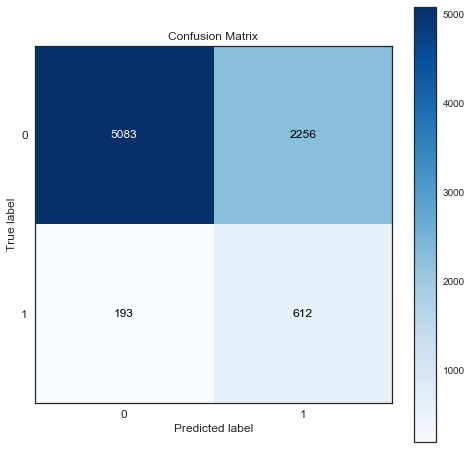

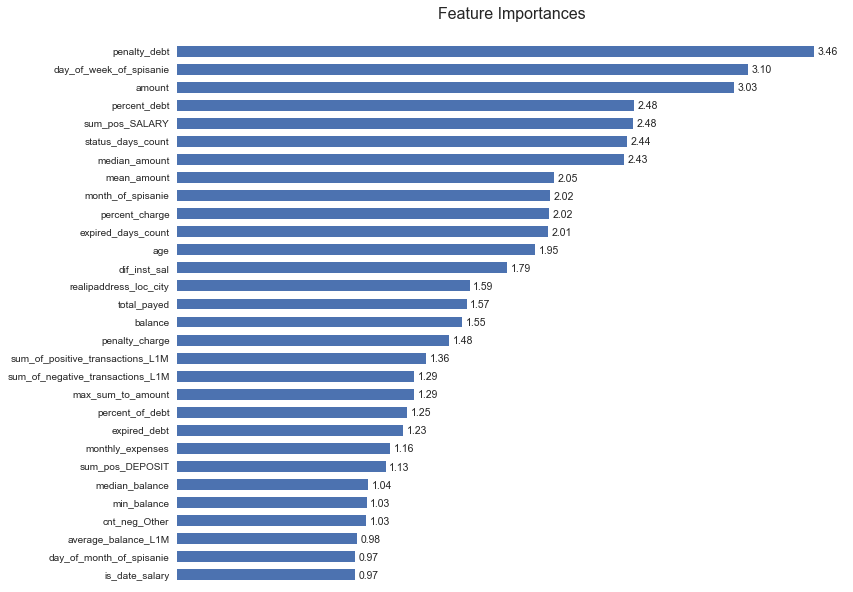

In [544]:
#IDF.plot_score(gs, X_test, y_test)
IDF.plot_score(clf, X_test, y_test)

In [80]:
joblib.dump(clf, 'BR_DD_alg.pkl');

In [545]:
df_test['prediction_proba'] = clf.predict_proba(X_test)[:,1]
writer = pd.ExcelWriter('V1_BR_DD.xlsx')
df_test[['amount','success', 'prediction_proba']].to_excel(writer,'BR_DD_TEST_DATA', index=False)
writer.save()

In [554]:
#df_test
print (classification_report(pd.Series(clf.predict_proba(X_test)[:,1]).apply(lambda x: 1 if x>0.1 else 0), y_test))

             precision    recall  f1-score   support

          0       0.34      0.98      0.51      2545
          1       0.95      0.14      0.24      5599

avg / total       0.76      0.40      0.32      8144



# Clusters

In [45]:
%%time
df = pd.read_sql('''
SELECT
    c.id AS credit_id,    
    ibat.*
FROM br_release_moneyman.credit c
    INNER JOIN br_release_moneyman.credit_risk_filter crf
        ON crf.credit_id = c.id
    INNER JOIN br_release_moneyman.instantor_bank_account iba
        ON iba.instantor_user_details_id = crf.instantor_user_details_id
    INNER JOIN br_release_moneyman.instantor_bank_account_transaction ibat
        ON ibat.instantor_bank_account_id = iba.id
WHERE c.date_requested>'2017-01-01'
''', con=con())

Wall time: 2min 41s


In [46]:
def clusters(x):
    if x.find('ENCARGOS') != -1 or x.find('Enc') != -1  or x.find('ITAU') != -1  and x.find('SOB') != -1  or x.find('SOB') != -1  and x.find('MED') != -1  or x.find('SOB') != -1  and x.find('MEDIDA-MULTA') != -1: 
        d = 'BANK CHARGES'
    elif x.find('LIS') != -1 or x.find('LIS/JUROS') != -1 or x.find('RECUPERACAO') != -1:
        d = 'BANK INTERESTS'
    elif x.find('DEB') != -1 and x.find('CESTA') != -1 or x.find('Tarifa') != -1 or x.find('TARIFA') != -1 or x.find('TAR') != -1 or x.find('Taxa') != -1 or x.find('Histórico') != -1 and x.find('Tarifa') != -1 or x.find('Histórico') != -1 and x.find('Tar') != -1 or x.find('Histórico') != -1 and x.find('Serviços') != -1 or x.find('Cart') != -1 or x.find('ANUIDADE') != -1:
        d = 'BANK TAXES'
    elif x.find('DEBITO') != -1 and x.find('AUTOM') != -1 or x.find('DEBITO') != -1 and x.find('AUT') != -1 or x.find('AUT.') != -1 and x.find('DEBITO') != -1 or x.find('DB') != -1 and x.find('AT') != -1:
        d = 'DIRECT DEBIT'
    elif x.find('DEBITO') != -1 and x.find('AUTOM') != -1 and x.find('EMPRESAS') != -1 and x.find('CONVENIADAS') != -1 and x.find('CREFISA') != -1:
        d = 'DIRECT DEBIT CREFISA'
    elif x.find('DEBITO') != -1 and x.find('AUTOM') != -1 and x.find('EMPRESAS') != -1 and x.find('CONVENIADAS') != -1 and x.find('SOROCRED') != -1:
        d = 'DIRECT DEBIT SOROCRED'
    elif x.find('CX.SEGUROS') != -1 or x.find('DEB') != -1 and x.find('AUTOR') != -1 and (x.find('PORTO') != -1 or x.find('LIBERTY') != -1 or x.find('TOKIO') != -1 or x.find('SUL') != -1 or x.find('MITSUI') != -1 or x.find('AZUL') != -1 or x.find('PORTOSEGMONITO') != -1) or x.find('MENSALIDADE') != -1 and x.find('SEGURO') != -1 or x.find('PGTO') != -1 and x.find('PROTECAO') != -1 or x.find('Seg') != -1 or x.find('SEGURO') != -1:
        d = 'INSURANCE'
    elif x.find('CEP') != -1 or x.find('CEP/JUROS') != -1 or x.find('DEB.JUROS') != -1 or x.find('JUROS') != -1 or x.find('Mora') != -1 or x.find('MULTA') != -1:
        d = 'INTERESTS'
    elif x.find('APL') != -1 or x.find('Apl.invest') != -1 or x.find('APLIC') != -1 or x.find('Aplic.em') != -1 and x.find('Papeis') != -1 or x.find('APLICACAO') != -1 or x.find('DEB') != -1 and x.find('CDC') != -1 or x.find('DEBITO') != -1 and x.find('CAPITALIZACAO') != -1 or x.find('Histórico') != -1 and x.find('Ourocap') != -1 or x.find('Histórico') != -1 and x.find('Aplicação') != -1 or x.find('PIC') != -1 or x.find('PREMIO') != -1 and x.find('VGBL') != -1 or x.find('PREST') != -1 and x.find('CDC') != -1:
        d = 'INVESTMENT'
    elif x.find('DEB.IOF') != -1 or x.find('Histórico') != -1 and x.find('I.O.F.') != -1 or x.find('IOF') != -1:
        d = 'IOF'
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Agiplan') != -1:
        d = 'LOAN AGIPLAN'
    elif x.find('Bx.ant.fin/emp') != -1 or x.find('LIQUIDACAO') != -1 or x.find('Histórico') != -1  and x.find('Empréstimo') != -1 or x.find('EMPRESTIMO') != -1 and x.find('CONSIGNADO') != -1 or x.find('CREDITO') != -1 and x.find('CONSIGNADO') != -1 or x.find('PARCELA') != -1 and x.find('CONSIGNADO') != -1 or x.find('PREST') != -1 and x.find('EMPREST') != -1 or x.find('PREST') != -1 and x.find('EMPR') != -1 or x.find('PREST') != -1 and x.find('HAB') != -1 or x.find('PREST') != -1 and x.find('EMPRESTIMOS/FINANCIAMENTOS') != -1 or x.find('DEB') != -1 and x.find('AUTOR') != -1 and x.find('CETELEM') != -1 or x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Acordo') != -1 and x.find('Cetelem') != -1:
        d = 'LOAN BANK'
    elif x.find('Histórico') != -1 and x.find('BV') != -1:
        d = 'LOAN BV'
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Crefisa') != -1 or x.find('DB') != -1 and x.find('CREFISA') != -1 or x.find('DEB') != -1 and x.find('AUTOR') != -1 and x.find('CREFISA') != -1 or x.find('Crefisa') != -1:
        d = 'LOAN CREFISA'   
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Geru') != -1 or x.find('Geru') != -1:
        d = 'LOAN GERU'  
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Jbcred') != -1 or x.find('Jbcred') != -1:
        d = 'LOAN JBCRED'   
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Omni') != -1 or x.find('Omni') != -1:
        d = 'LOAN OMNI'   
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1 and x.find('Simplic') != -1 or x.find('Simplic') != -1:
        d = 'LOAN SIMPLIC' 
    elif x.find('Pagto') != -1 and x.find('Cobranca') != -1  and x.find('Sorocred') != -1  or x.find('DEB') != -1  and x.find('AUTOR') != -1  and x.find('SOROCRED') != -1  or x.find('Sorocred') != -1:
        d = 'LOAN SOROCRED'
    elif x.find('PAGAMENTO') != -1  and x.find('CONTA') != -1  and x.find('CELULAR') != -1 :
        d = 'MOBILE BILL'
    elif x.find('Pague') != -1  and x.find('Recarga') != -1  or x.find('RECARGA') != -1 :
        d = 'MOBILE CREDITS'
    elif x.find('Prev-seg.vida') != -1  or x.find('DEBITO') != -1  and x.find('PREVIDENCIA') != -1 :
        d = 'RETIRENMENT'
    elif x.find('Histórico') != -1  and x.find('Aplicação') != -1  and x.find('Poupança') != -1  or x.find('APLIC') != -1  and x.find('POUP') != -1  or x.find('TRANSFERENCIA') != -1  and x.find('POUPANCA') != -1 :
        d = 'SAVINGS'
    elif x.find('DOC') != -1 or x.find('DOC/TED') != -1 or x.find('Doc/tedinternet') != -1 or x.find('EMISSAO') != -1  and x.find('DE') != -1  and x.find('DOC') != -1  or x.find('ENVIO') != -1  and x.find('TED') != -1  or x.find('Histórico') != -1  and x.find('TRANSF.RECURSO') != -1  or x.find('TBI') != -1  or x.find('TED') != -1  or x.find('Ted-e') != -1  or x.find('Ted-t') != -1 or x.find('TEF') != -1  or x.find('TEL') != -1  and x.find('TED') != -1  or x.find('TEV') != -1  and x.find('MESM') != -1  or x.find('TRANSF.RECURSO(E/') != -1  or x.find('TRANSF') != -1  or x.find('TRANSFERENCIA') != -1:
        d = 'TRANSFER'
    elif x.find('DEBITO') != -1 and x.find('VALE-TRANSPORTE') != -1:
        d = 'TRANSPORT'
    elif x.find('SAQUE') != -1  or x.find('SAQUETERMINAL') != -1  or x.find('ENVIO') != -1  and x.find('TEV') != -1  or x.find('CP') != -1  and x.find('ELECTRO') != -1  or x.find('SAQUECORRESPONDEN') != -1  or x.find('RETIRADA') != -1  or x.find('SQ') != -1  and x.find('CX') != -1  or x.find('SAQ') != -1  or x.find('RECIBO') != -1  and x.find('RETIRADA') != -1  or x.find('SAQUEPESSOAL') != -1  or x.find('CXE') != -1  and x.find('SAQUE') != -1  or x.find('Histórico') != -1  and x.find('Banco') != -1  and x.find('24') != -1 :
        d = 'WITHDRAWAL'
    #end of negative
    elif x.find('BOLSA') != -1 and x.find('FAMI') != -1:
        d = 'BOLSA FAMILIA'
    elif x.find('ESTORNO') != -1 or x.find('Histórico') != -1 and x.find('Estorno') != -1 or x.find('EST') != -1 or x.find('DOC') != -1 and x.find('DEVOLVIDO') != -1 or x.find('DEVOLUCAO') != -1 or x.find('DEVOL.') != -1 or x.find('DEVOLUC') != -1:
        d = 'CHARGEBACK'
    elif x.find('CHEQUE') != -1 and x.find('DEVOLVIDO') != -1 or x.find('Histórico') != -1 and x.find('Cheque') != -1 and x.find('Devolv') != -1 or x.find('Dev') != -1 and x.find('ch') != -1 or x.find('CH') != -1 and x.find('DEV') != -1 or x.find('DEV') != -1 and x.find('SEM') != -1 and x.find('FUNDOS') != -1:
        d = 'CHECK RETURN'
    elif x.find('dp') != -1 or x.find('depósito') != -1 or x.find('DEP') != -1  or x.find('Dep') != -1 or x.find('CEI') != -1 and x.find('DINHEIRO') != -1 or x.find('Dep') != -1 and x.find('Dinheiro') != -1 or x.find('Dep') != -1 and x.find('c/c') != -1 or x.find('DEP.DINH.') != -1 or x.find('Depos') != -1 or x.find('DEPOSITO') != -1 or x.find('Deposito') != -1 or x.find('DP') != -1 or x.find('TEC') != -1 and x.find('DEP') != -1 or x.find('TEC') != -1 and x.find('DEPOSITO') != -1 or x.find('DEPOSITO') != -1 and x.find('DINHEIRO') != -1:
        d = 'DEPOSIT'
    elif x.find('CRED') != -1 and x.find('FGTS') != -1 or x.find('PAGAMENTO') != -1 and x.find('BENEFICIOS') != -1 or x.find('Histórico') != -1 and x.find('Resgate') != -1 and x.find('Fundo') != -1:
        d = 'FGTS'
    elif x.find('CRED') != -1 and x.find('INSS') != -1 or x.find('Credito') != -1 and x.find('Inss') != -1:
        d = 'INSS'
    elif x.find('CRED') != -1 and x.find('JUROS') != -1:
        d = 'INTERESTS RETURN'
    elif x.find('FT') != -1 or x.find('PIC') != -1 or x.find('REND') != -1 or x.find('RES') != -1 or x.find('Resg.mer.aberto') != -1 or x.find('Resg.tit.capit.') != -1 or x.find('RESGATE') != -1 or x.find('Resgate') != -1 or x.find('REMUNERACAO') != -1 and x.find('CONTAMAX') != -1 or x.find('Resg') != -1 and x.find('Invest') != -1 or x.find('Resg') != -1 and x.find('Investplus') != -1:
        d = 'INVESTMENT'
    elif x.find('TED') != -1 and x.find('Alfa') != -1 or x.find('Alfa') != -1:
        d = 'LOAN ALFA'
    elif x.find('CONTRATACAO') != -1 or x.find('EMPR') != -1 or x.find('Emprest') != -1 or x.find('REST') != -1 or x.find('SOB') != -1 or x.find('CRED') != -1 and x.find('EMPR') != -1 or x.find('CREDITO') != -1 and x.find('CONTRATADO') != -1 or x.find('CREDITO') != -1 and x.find('CONSIGNADO') != -1 or x.find('CREDITO') != -1 and x.find('ITAUCOR') != -1:
        d = 'LOAN BANK'
    elif x.find('TED') != -1 and x.find('BV') != -1 or x.find('TED') != -1 and x.find('655.0001BV') != -1 or x.find('BV') != -1:
        d = 'LOAN BV'
    elif x.find('TED') != -1 and x.find('CETELEM') != -1 or x.find('CETELEM') != -1:
        d = 'LOAN CETELEM'
    elif x.find('TED') != -1 and x.find('COOPERATIVA') != -1:
        d = 'LOAN COOP'
    elif x.find('TED') != -1 and x.find('CREFISA') != -1 or x.find('CREFISA') != -1:
        d = 'LOAN CREFISA'
    elif x.find('TED') != -1 and x.find('JBCRED') != -1:
        d = 'LOAN JBCRED'
    elif x.find('TED') != -1 and x.find('LECCA') != -1 or x.find('LECCA') != -1:
        d = 'LOAN LECCA'
    elif x.find('TED') != -1 and x.find('OMNI') != -1 or x.find('OMNI') != -1:
        d = 'LOAN OMNI'
    elif x.find('SISPAG') != -1 and x.find('SOCINAL') != -1 or x.find('SOCINAL') != -1:
        d = 'LOAN SOCINAL'
    elif x.find('SISPAG') != -1 and x.find('SOROCRED') != -1 or x.find('SOROCRED') != -1 or x.find('Sorocred') != -1 or x.find('Receb') != -1 and x.find('Sorocred') != -1:
        d = 'LOAN SOROCRED'
    elif x.find('Brad') != -1 or x.find('CAIXA') != -1 and x.find('PREV') != -1 or x.find('CREDITO') != -1 and x.find('PREVIDENCIA') != -1 or x.find('Histórico') != -1 and x.find('Brasilprev') != -1 or x.find('Histórico') != -1 and x.find('PREVI') != -1 or x.find('Histórico') != -1 and x.find('PREVIDENCIA') != -1:
        d = 'RETIRENMENT'
    elif x.find('Trans Sal') != -1 or x.find('Ted Csal') != -1 or x.find('SALARIO') != -1 or x.find('ADIANTAMENTO') != -1 and x.find('SALARIO') != -1   or x.find('CONSOLIDACAO') != -1   and x.find('SALARIO') != -1   or x.find('Cred') != -1   and x.find('Salario') != -1   or x.find('Credt') != -1   and x.find('Salario') != -1   or x.find('CT') != -1   and x.find('SALARIO') != -1   or x.find('PAGTO') != -1   and x.find('SALARIO') != -1   or x.find('TEC') != -1   and x.find('SALARIO') != -1   or x.find('REMUNERACAO/SALARIO') != -1   or x.find('LIQUIDO') != -1   and x.find('VENCIMENTO') != -1   or x.find('PAGTO') != -1   and x.find('ADIANT') != -1   or x.find('FOLHA') != -1:
        d = 'SALARY'
    elif x.find('bx') != -1 or x.find('Histórico') != -1and x.find('Resgate') != -1  and x.find('Poupança') != -1  or x.find('Histórico') != -1  and x.find('Resgate') != -1  and x.find('Fundo') != -1  or x.find('INT') != -1  and x.find('RESGATE') != -1  or x.find('REM') != -1  and x.find('BASICA') != -1  or x.find('REMUNER') != -1  and x.find('BASICA') != -1  or x.find('Rendimentos') != -1  and x.find('Poup') != -1  or x.find('RESG') != -1  and x.find('POUP') != -1  or x.find('Resgate') != -1  and x.find('Fundos') != -1:
        d = 'SAVINGS'
    elif x.find('CRED') != -1 and x.find('TED') != -1 or x.find('DOC') != -1 and x.find('ELET') != -1 or x.find('TBI') != -1 or x.find('TRANSFERENCIA') != -1  or x.find('Transf') != -1  or x.find('AG.') != -1  and x.find('TEF') != -1  or x.find('CEI') != -1  and x.find('TEF') != -1  or x.find('CXE') != -1  and x.find('TEF') != -1  or x.find('DEC') != -1  and x.find('TEF') != -1  or x.find('Deb') != -1  and x.find('Transf') != -1  or x.find('DI') != -1  and x.find('DIN') != -1  or x.find('DOC') != -1  and x.find('RECEBIDO-TIT') != -1  or x.find('Doc') != -1  and x.find('Cred') != -1  or x.find('Doc') != -1  and x.find('Cred.autom*') != -1:
        d = 'TRANSFER'
    elif x.find('PARSEG-DES') != -1:
        d = 'UNEMPLOYMENT SUBSIDARY'
    #I made:
    elif x.find('CRED') != -1 or x.find('CRED TEV') != -1 or x.find('Crédito') != -1:
        d = 'Credit'
    elif x.find('CREDIARIO') != -1 or x.find('Estorno de Débito') != -1 or x.find('PAGTO DEV_CONTR') != -1:
        d = 'Refund' 
    elif x.find('Depósito Online') != -1:
        d = 'Deposit Online'
    elif x.find('FUND.COORD.DE') != -1:
        d = 'Student scholarship'  
    elif x.find('COMPRA INTER') != -1:
        d = 'International purchase' 
    elif x.find('fake transaction') != -1 or x.find('Histórico: Saldo Anterior, Documento: null') != -1 or x.find('INT PRE-PAGOXXXXX') != -1 or x.find('INT PAG TIT') != -1:
        d = 'Error'   
    else:
        d = 'Other'
    return d 

In [47]:
%%time
df.description = df.description.map(lambda x: x.replace('Description:', ' '))
df['cluster'] = df['description'].apply(lambda x: clusters(x))

Wall time: 3min 35s


In [48]:
df_aft_clust = df.copy()

In [49]:
#with date of request
df['day_of_month_of_tr'] = df.date.map(lambda x: x.day)
df['day_of_week_of_tr'] = df.date.map(lambda x: x.weekday())
df['isweekday'] = df.day_of_week_of_tr.map(lambda x: 1 if x==5 or x==6 else 0)

In [50]:
salaries = df[(df.cluster=='SALARY') & (df.amount>=150)][['credit_id', 'day_of_month_of_tr']].drop_duplicates()
salaries['day_of_month_of_tr'] = salaries['day_of_month_of_tr'].map(lambda x: str(x)+',')
salaries['salarie_dates'] = salaries.groupby(['credit_id'])['day_of_month_of_tr'].transform('sum')
salaries = salaries[['credit_id', 'salarie_dates']].drop_duplicates()

In [51]:
df['max_sum'] = df.groupby(['credit_id'])['amount'].transform('max')
day_of_sal = df[df.max_sum==df.amount][['credit_id', 'day_of_month_of_tr']]
day_of_sal = day_of_sal.rename(columns={'day_of_month_of_tr':'day_of_max_trans'})

In [52]:
df.drop(['day_of_month_of_tr','day_of_week_of_tr','isweekday'], axis=1, inplace=True)

# 2nd processing

In [53]:
#delete shit
df = df[df.cluster!='Error']
df.index = range(len(df.index))

## feature generation

In [54]:
%%time
#dates
df['min_date_month'] = df.groupby(['credit_id'])['date'].transform('min').apply(lambda x: x.month)
df['max_date_month'] = df.groupby(['credit_id'])['date'].transform('max').apply(lambda x: x.month)
df['min_date_day'] = df.groupby(['credit_id'])['date'].transform('min').apply(lambda x: x.day)
df['max_date_day'] = df.groupby(['credit_id'])['date'].transform('max').apply(lambda x: x.day)
df['min_date_year'] = df.groupby(['credit_id'])['date'].transform('min').apply(lambda x: x.year)
df['max_date_year'] = df.groupby(['credit_id'])['date'].transform('max').apply(lambda x: x.year)

df['count_transactions'] = df.groupby(['credit_id'])['credit_id'].transform('count')
#df['count_distinct_clusters'] = df.groupby(['credit_id'])['cluster'].transform('count').nunique()
#df['count_dates'] = df.groupby(['credit_id'])['date'].transform('count')

#amount 
df['mean_amount'] = df.groupby(['credit_id'])['amount'].transform('mean')
df['min_amount'] = df.groupby(['credit_id'])['amount'].transform('min')
df['max_amount'] = df.groupby(['credit_id'])['amount'].transform('max')
df['median_amount'] = df.groupby(['credit_id'])['amount'].transform('median')
df['sum_amount'] = df.groupby(['credit_id'])['amount'].transform('sum')
df['amount_type'] = df.amount.apply(lambda x: 1 if x>0 else 0)
df['amount_count_pos'] = df.groupby(['credit_id'])['amount_type'].transform('sum')
df['amount_count_neg'] = df['count_transactions'] - df['amount_count_pos']
df.drop('amount_type', axis = 1, inplace = True)
#balance
df['mean_balance'] = df.groupby(['credit_id'])['balance'].transform('mean')
df['min_balance'] = df.groupby(['credit_id'])['balance'].transform('min')
df['max_balance'] = df.groupby(['credit_id'])['balance'].transform('max')
df['median_balance'] = df.groupby(['credit_id'])['balance'].transform('median')
df['sum_balance'] = df.groupby(['credit_id'])['balance'].transform('sum')
df['balance_type'] = df.balance.apply(lambda x: 1 if x>0 else 0)
df['balance_count_pos'] = df.groupby(['credit_id'])['balance_type'].transform('sum')
df['balance_count_neg'] = df['count_transactions'] - df['balance_count_pos']
df.drop('balance_type', axis = 1, inplace = True)

df['balance_type'] = df['amount'].map(lambda x: 'pos' if x > 0 else 'neg' )

Wall time: 2min 10s


# Work with all features and concat them

## start with generated features

In [55]:
#делаем уникальные по каждому кредиту
df['date_day'] = df.date.apply(lambda x: x.day)
df1 = df.drop(['id', 'date', 'description', 'amount', 'balance', 
                'cluster', 'balance_type','date_day', 'instantor_bank_account_id'], axis = 1)
df1 = df1.drop_duplicates().reset_index().drop('index', axis = 1).set_index('credit_id')

In [56]:
#count distinct dates
df1['count_distinct_dates'] = df.groupby('credit_id').agg({'date_day': 'nunique'})
#count distinct clusteдаrs
df1['count_distinct_clusters'] = df.groupby('credit_id').agg({'cluster': 'nunique'})
#all descr grouped by credit_id
#df1['all_desc'] = df.groupby('credit_id').agg({'description': 'sum'}).description.map(lambda x: " ".join(x.split()))

## make transposed with transactions by amount and type features and work with them

In [57]:
def transponir_new(df):
        #columns pos
        poscols = ['credit_id','BANK CHARGES', 'BANK INTERESTS', 'BANK TAXES',
               'BOLSA FAMILIA', 'CHARGEBACK', 'CHECK RETURN', 'Credit', 'DEPOSIT',
               'DIRECT DEBIT', 'FGTS', 'INSS', 'INSURANCE', 'INTERESTS', 'INVESTMENT',
               'IOF', 'International purchase', 'LOAN ALFA', 'LOAN BANK', 'LOAN BV','LOAN CREFISA',
               'LOAN GERU', 'LOAN JBCRED', 'LOAN LECCA', 'LOAN OMNI', 'LOAN SIMPLIC','LOAN SOCINAL',
               'LOAN SOROCRED', 'MOBILE CREDITS','Other', 'RETIRENMENT', 'Refund', 'SALARY', 'SAVINGS',
               'Student scholarship', 'TRANSFER', 'UNEMPLOYMENT SUBSIDARY',
               'WITHDRAWAL']
        negcols = ['credit_id','BANK CHARGES', 'BANK INTERESTS', 'BANK TAXES',
               'CHARGEBACK', 'CHECK RETURN', 'Credit', 'DEPOSIT', 'DIRECT DEBIT',
               'INSURANCE', 'INTERESTS', 'INVESTMENT', 'IOF', 'International purchase',
               'LOAN AGIPLAN', 'LOAN ALFA', 'LOAN BANK', 'LOAN BV', 'LOAN CETELEM',
               'LOAN CREFISA', 'LOAN GERU', 'LOAN JBCRED', 'LOAN OMNI', 'LOAN SIMPLIC',
               'LOAN SOROCRED', 'MOBILE BILL', 'MOBILE CREDITS', 'Other',
               'RETIRENMENT', 'SALARY', 'SAVINGS', 'TRANSFER', 'TRANSPORT',
               'WITHDRAWAL']
        #df make summ positive
        df_sp = df[['credit_id', 'id', 'cluster', 'amount']][df.balance_type == 'pos']
        #считаем общую сумму по каждому кластеру и клиенту
        df_sp = df_sp.groupby(['credit_id', 'cluster']).agg({'amount': 'sum'})
        df_sp.reset_index(level=['credit_id', 'cluster'], inplace=True)
        df_sp = df_sp.pivot(index='credit_id', columns='cluster', values='amount').reset_index()
        q_pos = pd.DataFrame(columns=poscols)
        df_sp = pd.concat([q_pos, df_sp], axis=0, join='outer')
        df_sp.columns = 'sum_pos_' + df_sp.columns
        df_sp = df_sp.rename(columns = {'sum_pos_credit_id':'credit_id'})

        #df make summ negative
        df_sn = df[['credit_id', 'id', 'cluster', 'amount']][df.balance_type == 'neg']
        #считаем общую сумму по каждому кластеру и клиенту
        df_sn = df_sn.groupby(['credit_id', 'cluster']).agg({'amount': 'sum'})
        df_sn.reset_index(level=['credit_id', 'cluster'], inplace=True)
        df_sn = df_sn.pivot(index='credit_id', columns='cluster', values='amount').reset_index()
        q_neg = pd.DataFrame(columns=negcols)
        df_sn = pd.concat([q_neg, df_sn], axis=0, join='outer')
        df_sn.columns = 'sum_neg_' + df_sn.columns
        df_sn = df_sn.rename(columns = {'sum_neg_credit_id':'credit_id'})

        #df make count positive
        df_cp = df[['credit_id', 'id', 'cluster', 'amount']][df.balance_type == 'pos']
        #считаем общую сумму по каждому кластеру и клиенту
        df_cp = df_cp.groupby(['credit_id', 'cluster']).agg({'amount': 'count'})
        df_cp.reset_index(level=['credit_id', 'cluster'], inplace=True)
        df_cp = df_cp.pivot(index='credit_id', columns='cluster', values='amount').reset_index()
        q_pos = pd.DataFrame(columns=poscols)
        df_cp = pd.concat([q_pos, df_cp], axis=0, join='outer')
        df_cp.columns = 'cnt_pos_' + df_cp.columns
        df_cp = df_cp.rename(columns = {'cnt_pos_credit_id':'credit_id'})

        #df make count negative
        df_cn = df[['credit_id', 'id', 'cluster', 'amount']][df.balance_type == 'neg']
        #считаем общую сумму по каждому кластеру и клиенту
        df_cn = df_cn.groupby(['credit_id', 'cluster']).agg({'amount': 'count'})
        df_cn.reset_index(level=['credit_id', 'cluster'], inplace=True)
        df_cn = df_cn.pivot(index='credit_id', columns='cluster', values='amount').reset_index()
        q_neg = pd.DataFrame(columns=negcols)
        df_cn = pd.concat([q_neg, df_cn], axis=0, join='outer')
        df_cn.columns = 'cnt_neg_' + df_cn.columns
        df_cn = df_cn.rename(columns = {'cnt_neg_credit_id':'credit_id'})

        df_sum = pd.merge(df_sp, df_sn, on='credit_id', how ='outer').fillna(0).set_index('credit_id')
        cnt = pd.merge(df_cp, df_cn, on='credit_id', how = 'outer').fillna(0)
        return df_sum, cnt

In [58]:
df_sum, cnt = transponir_new(df)

In [59]:
cnt.shape

(86899, 71)

In [60]:
df2 = pd.merge(df1.reset_index(), df_sum.reset_index(), on='credit_id', how ='outer')
df3 = pd.merge(df2, cnt, on='credit_id', how ='outer')
df4 = pd.merge(df3, salaries, on='credit_id', how ='outer')

In [62]:
#here join df with data
df = pd.merge(df, df4, left_on='credit_id', right_on='credit_id', how ='left')

In [63]:
df_1 = pd.merge(df, day_of_sal.drop_duplicates(), left_on='credit_id', right_on='credit_id', how ='left')

In [64]:
df_1['max_sum_to_amount'] = df_1['max_sum']/df_1['amount'].map(lambda x: float(x))
df_1['is_date_eq_sal_date'] = np.where(df_1['day_of_month_of_spisanie'] == df_1['day_of_max_trans'], 1, 0)
df_1['dif_inst_sal'] = df_1['day_of_month_of_spisanie'] - df_1['day_of_max_trans']

In [65]:
df_1.salarie_dates = df_1.salarie_dates.map(lambda x: str(x)).replace('nan', 'Nonenone')

In [66]:
df_2 = df_1.copy()

In [67]:
def if_salary(df):
    q = []
    for i in range(len(df)):
        if df.salarie_dates[i].find(str(df.day_of_month_of_spisanie[i])) != -1:
            q.append(1)
        else:
            q.append(0)
    df['is_date_salary'] = q
    return df 

In [68]:
df_1 = if_salary(df_1)

In [30]:
clf = GradientBoostingClassifier(random_state=0, verbose = 1)
clf.fit(X_train, y_train)      
tuned_parameters = [{'learning_rate':np.arange(0.2, 1, 0.2)},
                     {'n_estimators':np.arange(60, 200, 20)},
                      {'max_depth':np.arange(2, 6, 1)}]
gs = GridSearchCV(clf, tuned_parameters, cv=5, verbose=True) 

      Iter       Train Loss   Remaining Time 
         1           1.2029            1.49m
         2           1.1701            1.42m
         3           1.1441            1.39m
         4           1.1207            1.38m
         5           1.1012            1.36m
         6           1.0832            1.34m
         7           1.0653            1.33m
         8           1.0514            1.31m
         9           1.0360            1.30m
        10           1.0230            1.28m
        20           0.9355            1.13m
        30           0.8756           58.90s
        40           0.8264           50.28s
        50           0.7842           41.82s
        60           0.7418           33.43s
        70           0.7022           25.11s
        80           0.6677           16.72s
        90           0.6387            8.35s
       100           0.6121            0.00s


In [172]:
gs.fit(X_train, y_train)

In [62]:
writer = pd.ExcelWriter('Inst_DATA.xlsx')
final.to_excel(writer,'Inst', index=False)
writer.save()